# PyTorch CNN on MNIST 

In [16]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import optim
import matplotlib.pyplot as plt

**Reading data from MNIST_dataset.csv**

In [17]:
data = pd.read_csv('MNIST_dataset.csv')

labels = torch.tensor(data.iloc[:, -1].values, dtype=torch.long)
pixels = data.iloc[:, :-1].values

channels     = 1
image_height = 28
image_width  = 28

pixels_array = pixels.reshape(-1, channels, image_height, image_width)
images = torch.tensor(pixels_array, dtype=torch.float32) / 255.0

**Splitting the dataset into training, validation and testing data**

In [18]:
training_split = 0.7
validation_split = 0.1
test_split = 0.2

first_split = test_split + validation_split
second_split = test_split / (validation_split + test_split)

X_train, X_remaining, y_train, y_remaining = train_test_split(images, labels, test_size=first_split, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=second_split, random_state=42)

train_data = TensorDataset(X_train, y_train)
valid_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

**Visualizing the data**

From: https://github.com/krayyalasomayajula/DTE2502/blob/main/ml_frameworks/pytorch.ipynb

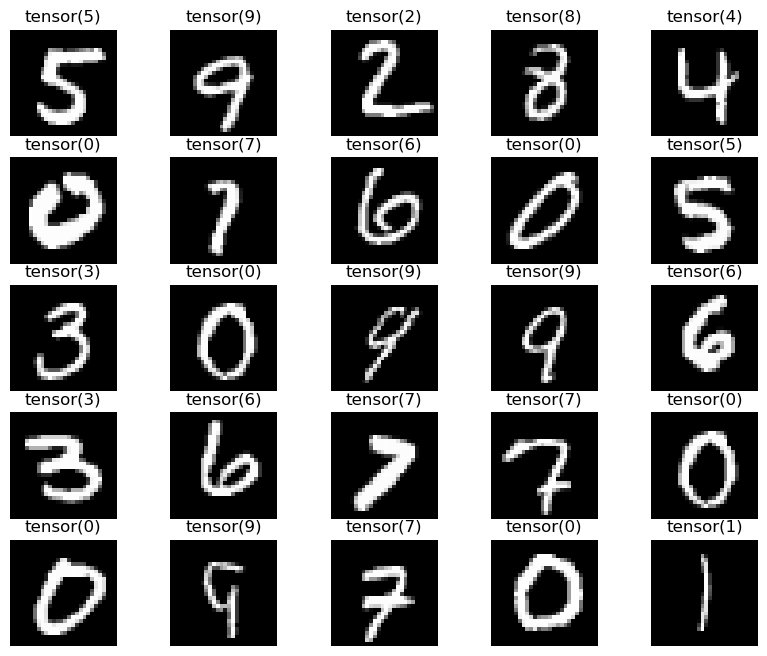

In [19]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

**Creating dataloaders**

In [20]:
from torch.utils.data import DataLoader

train_loader = torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1
                                          )
test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1
                                          )
valid_loader = torch.utils.data.DataLoader(valid_data,
                                            batch_size=100,
                                            shuffle=True,
                                            num_workers=1
                                            )
loaders = {
    'train' : train_loader,
    'test': test_loader,
    'valid': valid_loader
}

**Visualizing using dataloader**

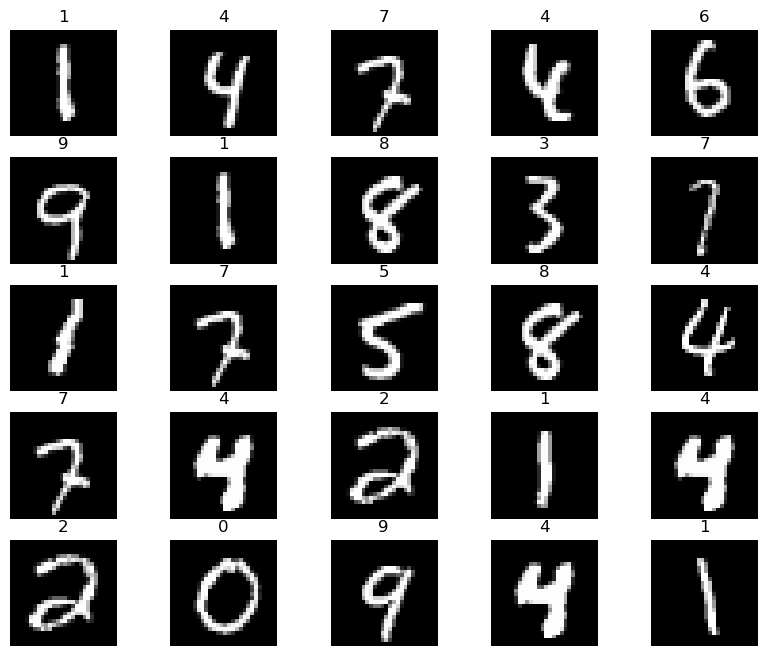

In [21]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5

imgs, labels = next(iter(loaders['train']))
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(imgs.shape[0], size=(1,)).item()
    img, label = imgs[sample_idx,:,:,:], labels[sample_idx].item()
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Model

In [22]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output

In [23]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


## Loss function

In [24]:
loss_func = nn.CrossEntropyLoss()
print(loss_func)

CrossEntropyLoss()


## Optimizer

In [25]:
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.01
    maximize: False
    weight_decay: 0
)

## Train the model

In [26]:
num_epochs = 10

def train(num_epochs, cnn, loaders):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            output = cnn(images)
            loss = loss_func(output, labels)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward() # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
            

In [27]:
train(num_epochs, cnn, loaders)

## Test the model on test dataset

In [28]:
def test():
    # Test the model
    cnn.eval()    
    with torch.no_grad():
        for images, labels in loaders['test']:
            test_output = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)

In [29]:
test()

Test Accuracy of the model on the 10000 test images: 0.80


## Print predictions

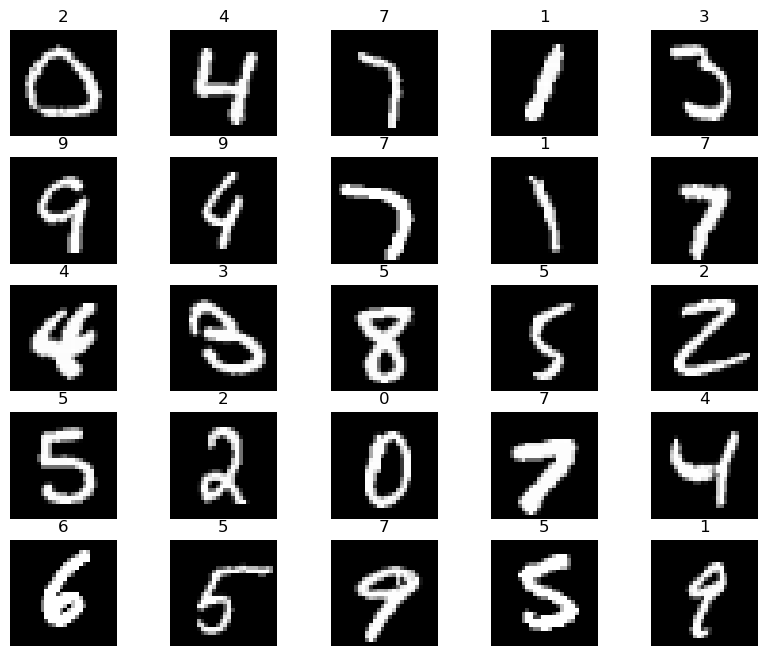

Prediction number: 	 [2 4 7 1 3 9 9 7 1 7 4 3 5 5 2 5 2 0 7 4 6 5 7 5 1]
Actual number: 	 	 [0 4 7 1 3 9 4 7 1 7 4 3 8 5 2 5 2 0 7 4 6 5 9 5 9]


In [30]:
imgs, lbls  = next(iter(loaders['test']))
true_labels = lbls[:25].numpy()

test_output = cnn(imgs[:25])
pred_labels = torch.max(test_output, 1)[1].data.numpy().squeeze()

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5

for i in range(1, cols * rows + 1):
    img, pred_label = imgs[i-1,:,:,:], pred_labels[i-1].item()
    figure.add_subplot(rows, cols, i)
    plt.title(pred_label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

print(f'Prediction number: \t {pred_labels}')
print(f'Actual number: \t \t {true_labels}')